In [2]:
"""
@author: Vu Hoang Viet
"""

import os
import sys
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
from utils import lmdb_dataset_loader
import matplotlib.pyplot as plt
import cv2
import time
import torch.nn.functional as F
from torchsummary import summary

In [3]:
class Extraction(nn.Module):

    def __init__(self):
        super(Extraction, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=4, kernel_size=4, stride=1, bias=False),
            nn.ReLU(True),
            nn.Conv2d(in_channels=4, out_channels=4, kernel_size=4, stride=1, bias=False),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=4, stride=2),
            nn.Conv2d(in_channels=4, out_channels=16, kernel_size=4, stride=1, bias=False),
            nn.ReLU(True),
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=4, stride=1, bias=False),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=4, stride=1),
            nn.Conv2d(in_channels=16, out_channels=64, kernel_size=4,stride=1, bias=False),
            nn.ReLU(True),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=4,stride=1, bias=False),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=4, stride=2),
        )

    def forward(self, input):
        """

        @param input:
        @return:
        """
        output = self.model(input)
        return output


class Generator(nn.Module):
    def __init__(self, max_features = 10):
        super(Generator, self).__init__()
        self.device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")
        self.max_features = max_features
        
        self.extractor = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=4, kernel_size=4, stride=1, bias=False),
            nn.ReLU(True),
            nn.Conv2d(in_channels=4, out_channels=4, kernel_size=4, stride=1, bias=False),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=4, stride=2),
            nn.Conv2d(in_channels=4, out_channels=16, kernel_size=4, stride=1, bias=False),
            nn.ReLU(True),
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=4, stride=1, bias=False),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=4, stride=1),
            nn.Conv2d(in_channels=16, out_channels=64, kernel_size=4,stride=1, bias=False),
            nn.ReLU(True),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=4,stride=1, bias=False),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=4, stride=2),
        )
        
        self.generate = nn.Sequential(
            nn.ConvTranspose2d(in_channels=64*self.max_features, out_channels=64, kernel_size=4, stride=2, bias=False),
            nn.ReLU(True),
            nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=4, stride=2, bias=False),
            nn.ReLU(True),
            nn.ConvTranspose2d(in_channels=64, out_channels=16, kernel_size=4, stride=2, bias=False),
            nn.ReLU(True),
            nn.ConvTranspose2d(in_channels=16, out_channels=16, kernel_size=3, stride=1, bias=False),
            nn.ReLU(True),
            nn.ConvTranspose2d(in_channels=16, out_channels=4, kernel_size=3, stride=1, bias=False),
            nn.ReLU(True),
            nn.ConvTranspose2d(in_channels=4, out_channels=4, kernel_size=4, stride=1, bias=False),
            nn.ReLU(True),
            nn.ConvTranspose2d(in_channels=4, out_channels=1, kernel_size=4, stride=1, bias=False),
            nn.Tanh()
        )

    def forward(self, input_imgs):
        """
        @param input:
        @return:
        """
        for input_img in input_imgs:
            input_img = torch.tensor(input_img).to(self.device)
            features_out = self.extractor(input_img.float())
            empty = torch.zeros((self.max_features - len(features_out),
                                 features_out.shape[1],
                                 features_out.shape[2],
                                 features_out.shape[3])).to(self.device)
            features_out = torch.cat(
                [features_out,empty
                 ],dim  = 0)
            features_out = features_out.reshape(1, 64*self.max_features,features_out.shape[2], features_out.shape[3])
            try:
                features_outs = torch.cat(
                    [features_outs,features_out
                     ],dim  = 0)
            except:
                features_outs = features_out
        output = self.generate(torch.tensor(features_outs))
        return output


class Discriminator(nn.Module):
    def __init__(self, num_classes):
        super(Discriminator, self).__init__()
        self.feature_extraction = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, bias=False),
            nn.ReLU(True),
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, stride=1, bias=False),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=4, stride=2),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, bias=False),
            nn.ReLU(True),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, bias=False),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=4, stride=2),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, bias=False),
            nn.ReLU(True),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, bias=False),
            nn.ReLU(True),
            nn.Flatten()
        )
        self.fake_real_model = nn.Linear(3136, 1)
        self.property_model = nn.Linear(3136, num_classes)

    def forward(self, input):
        """
        @param input:
        @return:
        """
        feature = self.feature_extraction(input)
        fake_real = F.sigmoid(self.fake_real_model(feature))
#         fake_real = self.fake_real_model(feature)
        property = self.property_model(feature)
        return fake_real, property

In [4]:
class HandWrittenGan:
    """
    Model class
    """

    def __init__(self,
                 target_size=(64, 64),
                 input_path=None,
                 target_path=None,
                 classes=None,
                 batch_size=1,
                 max_features=10,
                 max_iter=1e+5,
                 check_times = 1e+3):
        self.device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")
        self.classes = classes
        self.num_classes = len(classes)
        self.max_features = max_features
        self.real_label = 1
        self.fake_label = 0
        
        self.input_data = lmdb_dataset_loader(input_path)
        self.target_data = lmdb_dataset_loader(target_path)
        self.target_size = target_size
        self.batch_size = batch_size
        self.max_iter = max_iter
        self.check_times = check_times
        
        self.generator = Generator(max_features).to(self.device)
        self.discriminator = Discriminator(self.num_classes).to(self.device)
        self.logs = {}

    def data_loader(self):
        while True:
            labels = []
            input_imgs = []
            real_imgs = []
            for _ in range(self.batch_size):
                label_ind = np.random.randint(self.num_classes)
                label = self.classes[label_ind]
                input_img = []
                for _ in range(2):
                    img = np.array(self.input_data.random_sample(label))
                    img = cv2.resize(img, self.target_size, interpolation = cv2.INTER_AREA)
                    img = np.reshape(img, (1,self.target_size[0],self.target_size[1]))
                    input_img.append(img)
                for i in range(3,self.max_features):
                    if np.random.rand() < 0.5:
                        img = np.array(self.input_data.random_sample(label))
                        img = cv2.resize(img, self.target_size, interpolation = cv2.INTER_AREA)
                        img = np.reshape(img, (1,self.target_size[0],self.target_size[1]))
                    else:
                        img = np.zeros_like(img)
                    input_img.append(img)
                real_img = np.array(self.target_data.random_sample(label))
                real_img = cv2.resize(real_img, self.target_size, interpolation = cv2.INTER_AREA)
                real_img = np.reshape(real_img, (1,self.target_size[0],self.target_size[1]))
                labels.append(label_ind)
                input_imgs.append(input_img)
                real_imgs.append(real_img)
            yield np.array(labels), np.array(input_imgs)/255., np.array(real_imgs)/255.

    def trainer(self, epochs):
        """

        @return:
        """
        optimizerD = optim.Adam(self.discriminator.parameters(), lr=1e-4, betas=(0.5, 0.9))
        optimizerG = optim.Adam(self.generator.parameters(), lr=1e-4, betas=(0.5, 0.9))
#         optimizerD = optim.SGD(self.discriminator.parameters(), lr=1e-3, momentum=0.9)
#         optimizerG = optim.SGD(self.generator.parameters(), lr=1e-3, momentum=0.9)
        self.logs['d_loss_real'] = []
        self.logs['d_loss_fake'] = []
        self.logs['d_loss_cls_real'] = []
        loss_d1 = nn.MSELoss()
        loss_d2 = nn.CrossEntropyLoss()
        loss_g1 = nn.MSELoss()
        loss_g2 = nn.CrossEntropyLoss()
        l1_loss = nn.L1Loss()
        running_d_loss = 0
        running_g_loss = 0
        real_loss_plot = []
        fake_loss_plot = []
        mean_loss_plot = []
        for epoch in range(epochs):
            count = 0
            b = time.time()
            for labels, input_imgs, real_imgs in self.data_loader():
                if count >= self.max_iter:
                    break
                else:
                    count += 1
                optimizerD.zero_grad()
                real_imgs = torch.tensor(real_imgs).to(self.device)

                # Đánh label true fake images
                true_label = torch.full((self.batch_size,), self.real_label,dtype=torch.float,
                                             device=self.device)
                fake_label = torch.full((self.batch_size,), self.fake_label,dtype=torch.float,
                                             device=self.device)

                # Đánh label phân loại
                property_label = torch.tensor(labels,dtype=torch.long,
                                             device=self.device)

                # Training model D với ảnh reals
#                 for real_img in real_imgs:
#                     plt.imshow(real_img.cpu().detach().numpy()[0])
#                     plt.show()
                real_imgs = real_imgs.float().to(self.device)
                out_real_src, out_real_cls = self.discriminator(real_imgs)

                # Tạo ảnh fake bằng G-models từ features từ E-Models
                input_imgs = torch.tensor(input_imgs)
                x_fake = self.generator(input_imgs)
        
                out_fake_src, _ = self.discriminator(x_fake.detach())
                src = torch.cat((out_real_src, out_fake_src), axis = 0)     
                src = src.view(-1)
                label = torch.cat((true_label, fake_label), axis = 0)            
                
                d_loss_real = loss_d1(src, label)
#                 d_loss_real = torch.mean(1-out_real_src)+torch.mean(out_fake_src)
                d_loss_cls_real = loss_d2(out_real_cls, property_label)

# #                 # Training models D với ảnh fake
                
                d_loss = d_loss_real + d_loss_cls_real
                d_loss.backward()
#                 d_loss_fake.backward()
                optimizerD.step()
                
                running_d_loss += d_loss.item()
#                 running_d_loss += d_loss_fake.item()
                
#                 if count % (self.check_times//10) == 0:
                g_labels, g_input_imgs, g_real_imgs = next(self.data_loader())
                optimizerG.zero_grad()
                input_imgs = torch.tensor(g_input_imgs)
                x_fake = self.generator(g_input_imgs)
                out_fake_src, out_fake_cls = self.discriminator(x_fake.detach())
                out_fake_src = out_fake_src.view(-1)
                g_loss_fake = loss_g1(out_fake_src, true_label)
#                     g_loss_fake = torch.mean(1-out_fake_src)
                g_real_imgs = torch.tensor(g_real_imgs).to(self.device)
                g_real_imgs = g_real_imgs.float().to(self.device)
                g_property_label = torch.tensor(g_labels,dtype=torch.long,
                                             device=self.device)
                g_loss_cls_fake = loss_g2(out_fake_cls, g_property_label)
                loss_G_L1 = l1_loss(x_fake, g_real_imgs)
                g_loss = g_loss_fake + loss_G_L1*10 + g_loss_cls_fake
                g_loss.backward()
                optimizerG.step() 
                running_g_loss += g_loss.item()
                    
                if count % self.check_times == 0:
#                     print(out_real_cls)
#                     print(property_label)
#                     print(d_loss_cls_real)
                    d_loss = running_d_loss/self.check_times
                    g_loss = running_g_loss/self.check_times
                    real_loss_plot.append(d_loss)
                    fake_loss_plot.append(g_loss)
                    mean_loss_plot.append((d_loss+g_loss)/2)
                    print("[%3d,%10d], D_Loss: %10f, G_Loss: %10f, Mean Loss: %5f, Seconds/batch: %5f"%(epoch, count,d_loss, g_loss, (d_loss+g_loss)/2, (time.time() - b)/self.check_times))
                    b = time.time()
                    running_d_loss = 0
                    running_g_loss = 0  
                    if count % (self.check_times*10) == 0:
                        print("\n"*5)
#                         print(src)
#                         print(out_fake_src)
#                         plt.subplot(2, 1, 1)
                        plt.plot(real_loss_plot, label='d_loss')
                        plt.plot(fake_loss_plot, label='g_loss')
                        plt.plot(mean_loss_plot, label='mean_loss')
                        plt.show()
                        if count % (self.check_times*100) == 0:
                            for j in range(len(real_imgs)):
                                fig=plt.figure(figsize=(4, 2))
                                fig.add_subplot(1, 2, 1)
                                plt.imshow(real_imgs[j][0].cpu().detach().numpy())
                                fig.add_subplot(1, 2, 2)
                                plt.imshow(x_fake.cpu().detach().numpy()[j][0])
                                print(property_label[j])
                                print(torch.argmax(out_real_cls[j]))
                                print(torch.argmax(out_fake_cls[j]))
                                plt.show()
            print("Epochs %s finished."%str(epoch).zfill(4))
                    

    def predictor(self):
        """

        @return:
        """
        return

In [6]:
models = HandWrittenGan(
                 target_size=(64, 64),
                 input_path='/home/vietvh9/Project/OCR_Components/data/sources/synthtext_font_lmdb',
                 target_path='/home/vietvh9/Project/OCR_Components/data/sources/ETL_NIST_processed_v2.0_lmdb',
                 classes=[str(i) for i in range(10)],
                 batch_size=10,
                 max_features=3,
                 max_iter=1e+5,
                 check_times = 1e+2)

/home/vietvh9/Project/.envs/GAN/lib/python3.6/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/vietvh9/Project/.envs/GAN/lib/python3.6/site-packages/ipykernel_launcher.py:80: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/vietvh9/Project/.envs/GAN/lib/python3.6/site-packages/ipykernel_launcher.py:96: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[  0,       100], D_Loss:   2.477627, G_Loss:   9.236996, Mean Loss: 5.857311, Seconds/batch: 0.738024
[  0,       200], D_Loss:   1.845061, G_Loss:   8.862033, Mean Loss: 5.353547, Seconds/batch: 0.579609
[  0,       300], D_Loss:   1.250323, G_Loss:   9.032495, Mean Loss: 5.141409, Seconds/batch: 0.437869
[  0,       400], D_Loss:   1.120466, G_Loss:   8.434822, Mean Loss: 4.777644, Seconds/batch: 0.387495
[  0,       500], D_Loss:   0.955885, G_Loss:   8.175356, Mean Loss: 4.565621, Seconds/batch: 0.346299
[  0,       600], D_Loss:   0.857539, G_Loss:   7.593907, Mean Loss: 4.225723, Seconds/batch: 0.355275
[  0,       700], D_Loss:   0.801789, G_Loss:   7.605550, Mean Loss: 4.203669, Seconds/batch: 0.325750
[  0,       800], D_Loss:   0.742560, G_Loss:   7.627130, Mean Loss: 4.184845, Seconds/batch: 0.339545
[  0,       900], D_Loss:   0.647045, G_Loss:   7.366430, Mean Loss: 4.006738, Seconds/batch: 0.342566
[  0,      1000], D_Loss:   0.660371, G_Loss:   7.463968, Mean Loss: 4.06

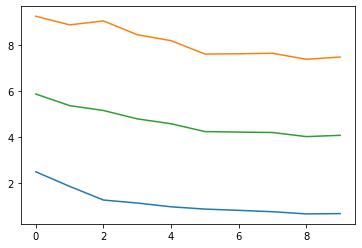

[  0,      1100], D_Loss:   0.574455, G_Loss:   7.736745, Mean Loss: 4.155600, Seconds/batch: 1.105901
[  0,      1200], D_Loss:   0.507883, G_Loss:   7.602061, Mean Loss: 4.054972, Seconds/batch: 1.140985
[  0,      1300], D_Loss:   0.497597, G_Loss:   7.177605, Mean Loss: 3.837601, Seconds/batch: 1.147421
[  0,      1400], D_Loss:   0.500122, G_Loss:   7.157153, Mean Loss: 3.828637, Seconds/batch: 1.066403
[  0,      1500], D_Loss:   0.455680, G_Loss:   7.317591, Mean Loss: 3.886635, Seconds/batch: 1.053941


In [ ]:
models.trainer(10)

In [ ]:
a = torch.tensor([[0.1414, 0.0866, 0.1143, 0.1201, 0.0862, 0.0844, 0.1058, 0.0871, 0.0762,
         0.0977],
        [0.2456, 0.0192, 0.1624, 0.1959, 0.0606, 0.0516, 0.0824, 0.0569, 0.0192,
         0.1062],
        [0.2344, 0.0240, 0.1467, 0.2067, 0.0627, 0.0563, 0.0861, 0.0587, 0.0227,
         0.1017],
        [0.2509, 0.0175, 0.1571, 0.2044, 0.0597, 0.0509, 0.0811, 0.0551, 0.0183,
         0.1050],
        [0.2332, 0.0192, 0.1614, 0.1983, 0.0632, 0.0540, 0.0800, 0.0587, 0.0195,
         0.1125],
        [0.2494, 0.0181, 0.1583, 0.1979, 0.0597, 0.0525, 0.0841, 0.0557, 0.0192,
         0.1051],
        [0.2445, 0.0182, 0.1573, 0.2014, 0.0632, 0.0518, 0.0793, 0.0561, 0.0192,
         0.1090],
        [0.2289, 0.0204, 0.1607, 0.1863, 0.0671, 0.0564, 0.0856, 0.0610, 0.0218,
         0.1117],
        [0.2207, 0.0241, 0.1619, 0.1893, 0.0660, 0.0568, 0.0853, 0.0632, 0.0224,
         0.1102],
        [0.2059, 0.0257, 0.1471, 0.1879, 0.0798, 0.0612, 0.0838, 0.0679, 0.0276,
         0.1131]])
b = torch.tensor([4, 3, 5, 3, 9, 9, 1, 1, 5, 6])

In [ ]:
l = nn.CrossEntropyLoss()

In [ ]:
l(a,b)